<h1>Spotify Charts Pipeline</h1>

<h2>Introduction</h2>

Spotify is one of the leading music streaming platforms in the world today. Founded in 2006, they initially used pirated tracks to demonstrate their proof of concept, but has since worked with record companies, big and small, and even with independent artists to rack up billions of streams across the world daily, thanks to their massive user base and proprietary algorithms.

<h2>Building the database</h2>

Using Python as our primary tool, we will build a database of Daily Top 200 Tracks, with a selection of regions and a specifiable date range. This can be accomplished through web scraping using Selenium Webdriver to simulate logins and opening of the chart page for each date, reading the HTML elements of that page, inserting into a SQLite database, then moving onto the chart page for the next date.

In [8]:
import pandas as pd

In [9]:
# regions in South East Asia with Spotify availability
# the regions can be split across multiple scraping notebooks and run simulatenously to save time,
# but keep in mind request limits
region_dict = {
    "id" : "Indonesia",
    "my" : "Malaysia",
    "ph" : "Philippines",
    "sg" : "Singapore",
    "th" : "Thailand",
    "vn" : "Vietnam"
}

In [3]:
# testing for one month
start_date = '2023-08-1'
end_date = '2023-08-31'
dates_list = pd.date_range(start=start_date, end=end_date).sort_values(ascending=True)

In [15]:
# this uses the firefox engine Geckodriver and sqlite as the database, make sure to have it installed
from selenium import webdriver
from selenium.webdriver.common.proxy import Proxy, ProxyType
from selenium.webdriver.firefox.service import Service
from webdriver_manager.firefox import GeckoDriverManager
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
from bs4 import BeautifulSoup
import time
import sqlite3

In [16]:
conn = sqlite3.connect('data/charts.db')
cursor = conn.cursor()

In [5]:
options = webdriver.FirefoxOptions()

driver = webdriver.Firefox(service=Service(GeckoDriverManager().install()), options=options)
print("Driver start")

driver.get("https://accounts.spotify.com/en/login?continue=https%3A%2F%2Fcharts.spotify.com/login")

username_field = driver.find_element(by="id", value="login-username")  # Replace with the actual username field ID
password_field = driver.find_element(by="id", value="login-password")  # Replace with the actual password field ID
login_button = driver.find_element(by="id", value="login-button")  # Replace with the actual login button ID

# Enter login credentials
username_field.send_keys("jerefe03@gmail.com")
password_field.send_keys("password123")

# Click the login button
login_button.click()

# Now you can perform your automation tasks after logging in

wait = WebDriverWait(driver, 10)
try:
    wait.until(EC.url_to_be('https://charts.spotify.com/charts/overview/global'))
    print("login success, redirecting")
    print("***")
    
    # main scraping logic
    for key in region_dict.keys():
        
        # todo: add mechanism to check if table already exists and has rows
        # but not reaching the end date (most likely disconnected), and if yes continue on the last date scraped

        cursor.execute(f'''
            CREATE TABLE IF NOT EXISTS {key} (
                title TEXT,
                rank INTEGER,
                date TEXT,
                artist TEXT,
                url TEXT,
                region TEXT,
                streams INTEGER
            )
        ''')

        sub_chart = pd.DataFrame()

        for date in dates_list:
            date_string = date.strftime("%Y-%m-%d")
            driver.get("https://charts.spotify.com/charts/view/regional-" + key + "-daily/" + date_string)
            try:
                WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.TAG_NAME, "tr")))
                print("Page load https://charts.spotify.com/charts/view/regional-" + key + "-daily/" + date_string + " success!")
                print("Scraping " + key + " " + date.strftime("%Y-%m-%d"))

                titles = driver.find_elements(By.CLASS_NAME, "kKOJRc")
                ranks = driver.find_elements(By.CLASS_NAME, "hgLxdb")
                artists = driver.find_elements(By.CLASS_NAME, "lfGOlT")
                artists = list(filter(lambda artists:\
                            len(artists.find_elements(By.CLASS_NAME, "bVVLJU")) > 0, artists))
                urls = driver.find_elements(By.CLASS_NAME, "gPJpnT")
                streams = driver.find_elements(By.CLASS_NAME, "cltvtH")

                for title, rank, artist_list, url, streams_count in zip (titles, ranks, artists, urls, streams):
                    title_string = title.text

                    rank_string = rank.text

                    artist_list_text_string = ""
                    artist_list_text = []
                    for artist in artist_list.find_elements(By.CLASS_NAME, "bVVLJU"):
                        artist_list_text.append(artist.text)
                    artist_list_text_string = ', '.join(map(str, artist_list_text))

                    anchor = url.find_element(By.TAG_NAME, "a")
                    anchor_string = anchor.get_attribute('href')

                    streams_count_string = streams_count.find_element(By.XPATH, './preceding-sibling::*[1]').text

                    cursor.execute(f'''INSERT INTO {key} (title, rank, date, artist, url, region, streams) VALUES (?, ?, ?, ?, ?, ?, ?)''',\
                                   (title_string, rank_string, date_string, artist_list_text_string, anchor_string, region_dict[key], streams_count_string))
                    # commit row to db
                    conn.commit()

                time.sleep(1)
            except:
                print("Page load https://charts.spotify.com/charts/view/regional-" + key + "-daily/" + date_string + " failed")
                print("Moving to next page..")
        
        print("sleeping for 10 seconds")
        print("***")
        time.sleep(10)
        
    print("Last date reached, ending driver")
    driver.quit()
        
except:
    print("login failed, ending driver")
    conn.close()
    driver.quit()

C:\Users\moshpit_yoshi\AppData\Local\Temp\ipykernel_10500\1455269411.py:3: DeprecationWarning: Firefox will soon stop logging to geckodriver.log by default; Specify desired logs with log_output
  driver = webdriver.Firefox(service=Service(GeckoDriverManager().install()), options=options)


Driver start
login success, redirecting
***
Page load https://charts.spotify.com/charts/view/regional-id-daily/2023-08-01 success!
Scraping id 2023-08-01
Page load https://charts.spotify.com/charts/view/regional-id-daily/2023-08-02 success!
Scraping id 2023-08-02
Page load https://charts.spotify.com/charts/view/regional-id-daily/2023-08-03 success!
Scraping id 2023-08-03
Page load https://charts.spotify.com/charts/view/regional-id-daily/2023-08-04 success!
Scraping id 2023-08-04
Page load https://charts.spotify.com/charts/view/regional-id-daily/2023-08-05 success!
Scraping id 2023-08-05
Page load https://charts.spotify.com/charts/view/regional-id-daily/2023-08-06 success!
Scraping id 2023-08-06
Page load https://charts.spotify.com/charts/view/regional-id-daily/2023-08-07 success!
Scraping id 2023-08-07
Page load https://charts.spotify.com/charts/view/regional-id-daily/2023-08-08 success!
Scraping id 2023-08-08
Page load https://charts.spotify.com/charts/view/regional-id-daily/2023-08-0

Page load https://charts.spotify.com/charts/view/regional-ph-daily/2023-08-13 success!
Scraping ph 2023-08-13
Page load https://charts.spotify.com/charts/view/regional-ph-daily/2023-08-14 success!
Scraping ph 2023-08-14
Page load https://charts.spotify.com/charts/view/regional-ph-daily/2023-08-15 success!
Scraping ph 2023-08-15
Page load https://charts.spotify.com/charts/view/regional-ph-daily/2023-08-16 success!
Scraping ph 2023-08-16
Page load https://charts.spotify.com/charts/view/regional-ph-daily/2023-08-17 success!
Scraping ph 2023-08-17
Page load https://charts.spotify.com/charts/view/regional-ph-daily/2023-08-18 success!
Scraping ph 2023-08-18
Page load https://charts.spotify.com/charts/view/regional-ph-daily/2023-08-19 success!
Scraping ph 2023-08-19
Page load https://charts.spotify.com/charts/view/regional-ph-daily/2023-08-20 success!
Scraping ph 2023-08-20
Page load https://charts.spotify.com/charts/view/regional-ph-daily/2023-08-21 success!
Scraping ph 2023-08-21
Page load 

Page load https://charts.spotify.com/charts/view/regional-th-daily/2023-08-25 success!
Scraping th 2023-08-25
Page load https://charts.spotify.com/charts/view/regional-th-daily/2023-08-26 success!
Scraping th 2023-08-26
Page load https://charts.spotify.com/charts/view/regional-th-daily/2023-08-27 success!
Scraping th 2023-08-27
Page load https://charts.spotify.com/charts/view/regional-th-daily/2023-08-28 success!
Scraping th 2023-08-28
Page load https://charts.spotify.com/charts/view/regional-th-daily/2023-08-29 success!
Scraping th 2023-08-29
Page load https://charts.spotify.com/charts/view/regional-th-daily/2023-08-30 success!
Scraping th 2023-08-30
Page load https://charts.spotify.com/charts/view/regional-th-daily/2023-08-31 success!
Scraping th 2023-08-31
sleeping for 10 seconds
***
Page load https://charts.spotify.com/charts/view/regional-vn-daily/2023-08-01 success!
Scraping vn 2023-08-01
Page load https://charts.spotify.com/charts/view/regional-vn-daily/2023-08-02 success!
Scrap

In [17]:
# get all table names corresponding to each region
region_tables = pd.read_sql_query("SELECT * FROM sqlite_master where type='table' AND name NOT LIKE 'sqlite_%' AND name NOT LIKE '%track_data';", conn)["name"]

In [18]:
# scraped region tables
region_tables

0    id
1    my
2    ph
3    sg
4    th
5    vn
Name: name, dtype: object

In [19]:
# combine chart tables into one dataframe
charts_df = pd.DataFrame()

In [20]:
for region in region_tables:
    charts_df = charts_df.append(pd.read_sql_query("SELECT * FROM " + region, conn))

C:\Users\moshpit_yoshi\AppData\Local\Temp\ipykernel_7444\1600905904.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  charts_df = charts_df.append(pd.read_sql_query("SELECT * FROM " + region, conn))
C:\Users\moshpit_yoshi\AppData\Local\Temp\ipykernel_7444\1600905904.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  charts_df = charts_df.append(pd.read_sql_query("SELECT * FROM " + region, conn))
C:\Users\moshpit_yoshi\AppData\Local\Temp\ipykernel_7444\1600905904.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  charts_df = charts_df.append(pd.read_sql_query("SELECT * FROM " + region, conn))
C:\Users\moshpit_yoshi\AppData\Local\Temp\ipykernel_7444\1600905904.py:2: FutureWarning: The frame.append method is deprecated and

In [27]:
# check number of scraped rows per region
charts_df["region"].value_counts()

Indonesia      6200
Malaysia       6200
Philippines    6200
Singapore      6200
Thailand       6200
Vietnam        6200
Name: region, dtype: int64

In [28]:
# extract track_id from url and drop url column
charts_df["track_id"] = charts_df["url"].str.replace("https://open.spotify.com/track/", "")

C:\Users\moshpit_yoshi\AppData\Local\Temp\ipykernel_7444\3844909009.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  charts_df["track_id"] = charts_df["url"].str.replace("https://open.spotify.com/track/", "")


In [29]:
charts_df.drop("url", axis=1, inplace=True)

<h2>Check completeness in terms of date</h2>

looking deeper into the dataset using time series

In [30]:
# convert "date" column from string into pandas datetime then set as index
charts_df["date"] = pd.to_datetime(charts_df["date"])
charts_df.set_index("date", inplace=True)

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

In [32]:
def plot_region_chart_row_count_across_time(chart):
    plt.figure(figsize=(12, 3))
    sns.lineplot(data=chart.resample("D").size())
    plt.xticks(rotation=75, fontsize=7.5)
    plt.ylabel("row count")
    plt.title("Count of rows scraped per day")
    plt.show()

In [33]:
def plot_region_chart_row_count_distribution(chart):
    per_date_count = chart["track_id"].groupby(["date"]).count()
    sns.histplot(per_date_count)
    plt.title("Distribution of number of rows scraped")
    plt.ylabel("count of days")
    plt.xlabel("rows in day")
    plt.show()

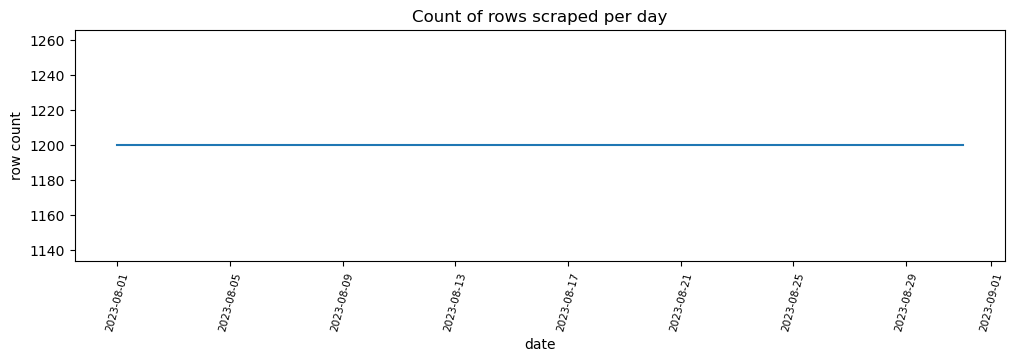

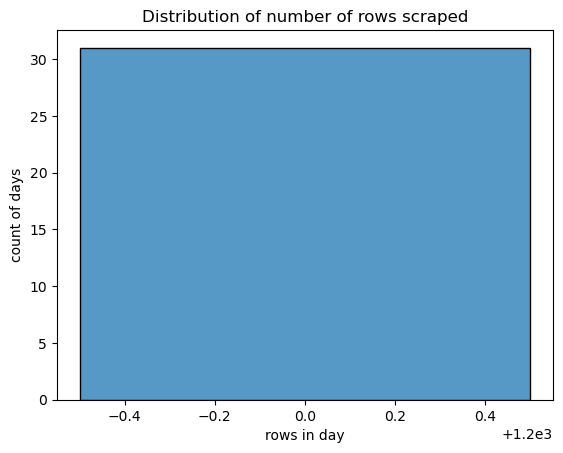

In [34]:
plot_region_chart_row_count_across_time(charts_df)
plot_region_chart_row_count_distribution(charts_df)

In [35]:
# check for missing days
date_range = pd.date_range(start=charts_df.index.min(), end=charts_df.index.max())

In [36]:
date_range

DatetimeIndex(['2023-08-01', '2023-08-02', '2023-08-03', '2023-08-04',
               '2023-08-05', '2023-08-06', '2023-08-07', '2023-08-08',
               '2023-08-09', '2023-08-10', '2023-08-11', '2023-08-12',
               '2023-08-13', '2023-08-14', '2023-08-15', '2023-08-16',
               '2023-08-17', '2023-08-18', '2023-08-19', '2023-08-20',
               '2023-08-21', '2023-08-22', '2023-08-23', '2023-08-24',
               '2023-08-25', '2023-08-26', '2023-08-27', '2023-08-28',
               '2023-08-29', '2023-08-30', '2023-08-31'],
              dtype='datetime64[ns]', freq='D')

In [37]:
for region in charts_df["region"].unique():
    print("Missing days: " + region)
    print(date_range[~date_range.isin(charts_df[charts_df["region"]==region].index)])
    print("***")

Missing days: Indonesia
DatetimeIndex([], dtype='datetime64[ns]', freq='D')
***
Missing days: Malaysia
DatetimeIndex([], dtype='datetime64[ns]', freq='D')
***
Missing days: Philippines
DatetimeIndex([], dtype='datetime64[ns]', freq='D')
***
Missing days: Singapore
DatetimeIndex([], dtype='datetime64[ns]', freq='D')
***
Missing days: Thailand
DatetimeIndex([], dtype='datetime64[ns]', freq='D')
***
Missing days: Vietnam
DatetimeIndex([], dtype='datetime64[ns]', freq='D')
***


In [38]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [39]:
# summary statistics
for region in charts_df["region"].unique():
    print("Summary statistics for streams: " + region)
    print(charts_df[charts_df["region"]==region]["streams"].str.replace(",","").astype(int).describe())
    print("***")

Summary statistics for streams: Indonesia
count      6200.000
mean     228771.722
std      157735.924
min      101858.000
25%      132848.000
50%      166419.000
75%      272916.250
max     1356440.000
Name: streams, dtype: float64
***
Summary statistics for streams: Malaysia
count     6200.000
mean     23362.226
std      14698.060
min      11974.000
25%      14789.000
50%      17979.500
75%      26403.250
max     140017.000
Name: streams, dtype: float64
***
Summary statistics for streams: Philippines
count     6200.000
mean    134399.209
std      92452.315
min      65854.000
25%      81286.750
50%      99070.000
75%     153085.500
max     819529.000
Name: streams, dtype: float64
***
Summary statistics for streams: Singapore
count     6200.000
mean     13311.795
std      10115.792
min       6769.000
25%       8637.750
50%      10382.500
75%      14318.250
max     131924.000
Name: streams, dtype: float64
***
Summary statistics for streams: Thailand
count      6200.000
mean      48626.21

<h2>Get Track Data using Spotify Web Api and SpotiPy</h2>

We can get track information from Spotify Web Api and combine it with our previously extracted chart data. To do this, we identify the unique tracks in our chart data, get the track_ids of the unique tracks and and loop the track data getter over this list.

In [40]:
import time
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

In [41]:
# track data getter function
def get_track_data(t_id, client_id_param, client_secret_param):
    client_credentials_manager = SpotifyClientCredentials(client_id=client_id_param,
                                                          client_secret=client_secret_param)
    sp = spotipy.Spotify(client_credentials_manager = client_credentials_manager)
    
    track_data = sp.track(t_id)
    track_features = sp.audio_features(t_id)
    
    #get only main(first) artist
    td_list = [t_id,\
               track_data['name'],\
               track_data['artists'][0]['id'],\
               track_data['artists'][0]['name'],\
               track_data['album']['uri'].split(":")[2],\
               track_data['duration_ms'],\
               track_data['album']['release_date'],\
               track_data['popularity']]
    data = pd.DataFrame([td_list], columns = ['track_id','track_name','artist_id','artist_name','album_id','duration','release_date','popularity'])

    relevant_cols = ['danceability', 'energy', 'key', 'loudness', 'mode',\
                     'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']  
    
    #if audio features are not available
    if track_features==[None]:
        tf_data = pd.DataFrame([{x:None for x in relevant_cols}])
    else:
        tf_data = pd.DataFrame(track_features)
        tf_data = tf_data[relevant_cols]
    
    data = pd.concat([data, tf_data], axis=1)
    return data

In [42]:
downloaded_track_ids = []

def get_tracks_slice_data(tracks_slice, client_id_param, client_secret_param):

    track_df = tracks_slice
    track_list = track_df['track_id'].values
    
    for i,track_id in enumerate(track_list):    
        if track_id in downloaded_track_ids:
            continue
        else:
            print('[%d/%d] Fetching track data for %s... ' % 
                  (i+1,len(track_list),track_df[track_df['track_id']==track_id]['title'].values[0]), end = " ") 

            try:
                track_data = get_track_data(track_id, client_id_param, client_secret_param) 
                downloaded_track_ids.append(track_id)
                cursor.execute(f'''INSERT INTO track_data (track_id, track_name, artist_id, artist_name, album_id, duration, release_date, popularity, danceability, energy, key, loudness, mode, speechiness, acousticness, instrumentalness, liveness, valence, tempo) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)''',\
                                   (track_data["track_id"][0],
                                    track_data["track_name"][0],
                                    track_data["artist_id"][0],
                                    track_data["artist_name"][0],
                                    track_data["album_id"][0],
                                    int(track_data["duration"][0]),
                                    track_data["release_date"][0],
                                    int(track_data["popularity"][0]),
                                    float(track_data["danceability"][0]),
                                    float(track_data["energy"][0]),
                                    int(track_data["key"][0]),
                                    float(track_data["loudness"][0]),
                                    int(track_data["mode"][0]),
                                    float(track_data["speechiness"][0]),
                                    float(track_data["acousticness"][0]),
                                    float(track_data["instrumentalness"][0]),
                                    float(track_data["liveness"][0]),
                                    float(track_data["valence"][0]),
                                    float(track_data["tempo"][0])))
                conn.commit()
                print("done!")
            except Exception as e:
                print(e)

            # sleep for 100 secs per 100 requests to avoid being blocked
            if (i % 100 == 0)&(i > 0):
                time.sleep(10)

In [43]:
# tracks_slice: so we can distribute retrieval of track data across client_ids and client_secrets for bigger datasets
# downloaded_track_ids: so we can continue on last track data retrieved in case of disconnection

In [44]:
# get unique tracks in charts
charts_unique_tracks = charts_df.groupby(["title", "artist", "track_id"]).size().reset_index(name="count")

In [45]:
charts_unique_tracks.sort_values(by="count", ascending=False)

,title,artist,track_id,count
195,Die For You,The Weeknd,2LBqCSwhJGcFQeTHMVGwy3,186
104,Blank Space,Taylor Swift,1u8c2t2Cy7UBoG4ArRcF5g,186
639,Seven (feat. Latto) (Explicit Ver.),"Jung Kook, Latto",7x9aauaA9cu6tyfpHnqDLo,186
196,Die For You (with Ariana Grande) - Remix,"The Weeknd, Ariana Grande",4W4fNrZYkobj539TOWsLO2,186
170,Cupid - Twin Ver.,FIFTY FIFTY,7FbrGaHYVDmfr7KoLIZnQ7,186
...,...,...,...,...
525,Our Singapore,JJ Lin,5WtMlbTDNZlbN8xZ5zfXva,1
844,Without You,高爾宣 OSN,0KWnRv3wxjltYVB3MqjNd2,1
323,In A Heartbeat,Sylvia Ratonel,14dThbrteRM57dxmpV26a8,1
181,DELRESTO (ECHOES) (feat. Beyoncé),"Travis Scott, Beyoncé",0OEe83mMZ5kaNw5uZQ7ilG,1


In [46]:
charts_unique_tracks

,title,artist,track_id,count
0,(It Goes Like) Nanana - Edit,Peggy Gou,23RoR84KodL5HWvUTneQ1w,41
1,10 Ngàn Năm,PC,76KYaCx7UjHwlnrqzcovLZ,31
2,17,Dept,3LejSFG20mSl4IzORHa7Ya,31
3,18,One Direction,3JjnGLK8IxkNLvo8Lb3KOM,31
4,2 faces,Mark Tuan,3I7s9xEyLFWbEDtsv7vYt3,7
...,...,...,...,...
1122,說好不哭,"Jay Chou, Ashin Chen",77BQceOpfvUBXgokOFHYMm,18
1123,遇見,Stefanie Sun,3xJK8ywApYVEYIDhymYMC6,15
1124,那些你很冒險的夢,JJ Lin,2aMN1ky0SzSEcV1QdBYbW9,30
1125,青のすみか,Tatsuya Kitani,12usPU2WnqgCHAW1EK2dfd,10


In [47]:
# divide tracks to avoid timeouts from API
tracks_slice_1 = charts_unique_tracks[0:570]
tracks_slice_2 = charts_unique_tracks[570:]

In [48]:
tracks_slices = [
    tracks_slice_1,
    tracks_slice_2
]

client_ids = [
    "fe07a9a23ea54344be9aa80e33d7583b",
    "9971fa3231494ce9aa0bf8fc22622044"
]

client_secrets = [
    "710d45475521432db507f82d4f99fd54",
    "a4c187a9c6ac4b4fb01ea30cc51cfdd6"
]

In [49]:
conn = sqlite3.connect('data/charts.db')
cursor = conn.cursor()

cursor.execute(f'''
    CREATE TABLE IF NOT EXISTS track_data (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        track_id TEXT,
        track_name TEXT,
        artist_id TEXT,
        artist_name TEXT,
        album_id TEXT,
        duration INTEGER,
        release_date TEXT,
        popularity INTEGER,
        danceability FLOAT,
        energy FLOAT,
        key INTEGER,
        loudness FLOAT,
        mode INTEGER,
        speechiness FLOAT,
        acousticness FLOAT,
        instrumentalness FLOAT,
        liveness FLOAT,
        valence FLOAT,
        tempo FLOAT
    )
''')

In [50]:
for iteration in range(0,2):
    print("***")
    print("Iteration " + str(iteration))
    get_tracks_slice_data(tracks_slices[iteration], client_ids[iteration], client_secrets[iteration])

***
Iteration 0
[1/570] Fetching track data for (It Goes Like) Nanana - Edit...  done!
[2/570] Fetching track data for 10 Ngàn Năm...  done!
[3/570] Fetching track data for 17...  done!
[4/570] Fetching track data for 18...  done!
[5/570] Fetching track data for 2 faces...  done!
[6/570] Fetching track data for 2002...  done!
[7/570] Fetching track data for 2AM...  done!
[8/570] Fetching track data for 3 1 0 7 (feat. Duongg & Nâu)...  done!
[9/570] Fetching track data for 3 1 0 7 - 2 (feat. W/N & Nau)...  done!
[10/570] Fetching track data for 3 1 0 7 7 - W/N ft. ( titie, Duongg )...  done!
[11/570] Fetching track data for 3 AM...  done!
[12/570] Fetching track data for 31 Ogos...  done!
[13/570] Fetching track data for 3107 3...  done!
[14/570] Fetching track data for 3107 4 (feat. Erik, Nâu)...  done!
[15/570] Fetching track data for A Sky Full of Stars...  done!
[16/570] Fetching track data for A Thousand Years...  done!
[17/570] Fetching track data for A Year Ago...  done!
[18/570]

[131/570] Fetching track data for Calling (Spider-Man: Across the Spider-Verse) (Metro Boomin & Swae Lee, NAV, feat. A Boogie Wit da Hoodie)...  done!
[132/570] Fetching track data for Calm Down (with Selena Gomez)...  done!
[133/570] Fetching track data for Can I Be Him...  done!
[134/570] Fetching track data for Car's Outside...  done!
[135/570] Fetching track data for Car's Outside - Sped Up Version...  done!
[136/570] Fetching track data for Carry Me Out...  done!
[137/570] Fetching track data for Cheating on You...  done!
[138/570] Fetching track data for Chemical...  done!
[139/570] Fetching track data for Cho Tôi Lang Thang...  done!
[140/570] Fetching track data for Choosy...  done!
[141/570] Fetching track data for Christmas Tree...  done!
[142/570] Fetching track data for Chuyện Rằng...  done!
[143/570] Fetching track data for Chuyện Đôi Ta (feat. Muộii)...  done!
[144/570] Fetching track data for Chìm Sâu...  done!
[145/570] Fetching track data for Chúng Ta Của Hiện Tại...  

[264/570] Fetching track data for Give Me Your Forever...  done!
[265/570] Fetching track data for Già Cùng Nhau Là Được...  done!
[266/570] Fetching track data for Giấc Mơ Khác...  done!
[267/570] Fetching track data for Glimpse of Us...  done!
[268/570] Fetching track data for Gone...  done!
[269/570] Fetching track data for Gusto feat. Al James...  done!
[270/570] Fetching track data for Gác Lại Âu Lo (feat. Miu Lê)...  done!
[271/570] Fetching track data for HEAVEN AND BACK...  done!
[272/570] Fetching track data for Habang Buhay...  done!
[273/570] Fetching track data for Haegeum...  done!
[274/570] Fetching track data for Halik...  done!
[275/570] Fetching track data for Hanggang Kailan - Umuwi Ka Na Baby...  done!
[276/570] Fetching track data for Hangin...  done!
[277/570] Fetching track data for Hanya Aku...  done!
[278/570] Fetching track data for Hanya Kau Yang Mampu...  done!
[279/570] Fetching track data for Hapus Aku...  done!
[280/570] Fetching track data for Hard to Lov

[402/570] Fetching track data for Like Crazy (English Version)...  done!
[403/570] Fetching track data for Lilith (feat. SUGA of BTS) (Diablo IV Anthem)...  done!
[404/570] Fetching track data for Liệu Giờ...  done!
[405/570] Fetching track data for Locked out of Heaven...  done!
[406/570] Fetching track data for Loneliness...  done!
[407/570] Fetching track data for Long Live (Taylor's Version)...  done!
[408/570] Fetching track data for Lost Jigsaw...  done!
[409/570] Fetching track data for Love...  done!
[410/570] Fetching track data for Love At First Light...  done!
[411/570] Fetching track data for Love In The Dark...  done!
[412/570] Fetching track data for Love Me Again...  done!
[413/570] Fetching track data for Love Story (Taylor’s Version)...  done!
[414/570] Fetching track data for Love U Like That...  done!
[415/570] Fetching track data for Love Yourself...  done!
[416/570] Fetching track data for Lover...  done!
[417/570] Fetching track data for Lovesick Girls...  done!
[

[537/570] Fetching track data for Paki Sabi...  done!
[538/570] Fetching track data for Palagi...  done!
[539/570] Fetching track data for Pamit...  done!
[540/570] Fetching track data for Pano...  done!
[541/570] Fetching track data for Paper Rings...  done!
[542/570] Fetching track data for Paraluman...  done!
[543/570] Fetching track data for Pasilyo...  done!
[544/570] Fetching track data for Payphone...  done!
[545/570] Fetching track data for Pelangi...  done!
[546/570] Fetching track data for Pelikula...  done!
[547/570] Fetching track data for People...  done!
[548/570] Fetching track data for People Pt.2 (feat. IU)...  done!
[549/570] Fetching track data for Perahu Kertas...  done!
[550/570] Fetching track data for Perfect...  done!
[551/570] Fetching track data for Pergilah Cinta...  done!
[552/570] Fetching track data for Pesan Terakhir...  done!
[553/570] Fetching track data for Photograph...  done!
[554/570] Fetching track data for Pilihan Yang Terbaik...  done!
[555/570] 

[105/557] Fetching track data for Somewhere Only We Know...  done!
[106/557] Fetching track data for Song for Singapore...  done!
[107/557] Fetching track data for Sorai...  done!
[108/557] Fetching track data for Sparks Fly (Taylor’s Version)...  done!
[109/557] Fetching track data for Speak Now (Taylor's Version)...  done!
[110/557] Fetching track data for Speed Drive (From Barbie The Album)...  done!
[111/557] Fetching track data for Spicy...  done!
[112/557] Fetching track data for Sprinter...  done!
[113/557] Fetching track data for Stand Up For Singapore...  done!
[114/557] Fetching track data for Starboy...  done!
[115/557] Fetching track data for Starlight...  done!
[116/557] Fetching track data for Steal The Show - From "Elemental"...  done!
[117/557] Fetching track data for Still With You...  done!
[118/557] Fetching track data for Still into You...  done!
[119/557] Fetching track data for Stitches...  done!
[120/557] Fetching track data for Strawberries & Cigarettes...  done

[236/557] Fetching track data for Untuk Perempuan Yang Sedang Di Pelukan...  done!
[237/557] Fetching track data for Usai...  done!
[238/557] Fetching track data for Used To Be Young...  done!
[239/557] Fetching track data for Usik...  done!
[240/557] Fetching track data for Very Very Small...  done!
[241/557] Fetching track data for Victoria's Secret...  done!
[242/557] Fetching track data for Vinflow...  done!
[243/557] Fetching track data for Viva La Vida...  done!
[244/557] Fetching track data for Vành Khuyên Nhỏ (feat. Liu Grace)...  done!
[245/557] Fetching track data for Vì Anh Đâu Có Biết...  done!
[246/557] Fetching track data for Vì Em Chưa Bao Giờ Khóc...  done!
[247/557] Fetching track data for VỀ QUÊ (feat. Mikelodic & Đặng Thái Bình)...  done!
[248/557] Fetching track data for W.R.U...  done!
[249/557] Fetching track data for WONDERLAND...  done!
[250/557] Fetching track data for Waiting For You...  done!
[251/557] Fetching track data for Wajahmu Mengalihkan Duniaku...  d

[369/557] Fetching track data for กอดความเจ็บช้ำ ( Carry )...  done!
[370/557] Fetching track data for การเดินทางที่สวยงาม...  done!
[371/557] Fetching track data for กาลครั้งนึง...  done!
[372/557] Fetching track data for กำแพงหัวใจ...  done!
[373/557] Fetching track data for ของขวัญ...  done!
[374/557] Fetching track data for ขอให้เธอใจดี...  done!
[375/557] Fetching track data for ขอให้โลกนี้ใจดีกับเธอ...  done!
[376/557] Fetching track data for ขี้หึง...  done!
[377/557] Fetching track data for ข้างกัน (City)...  done!
[378/557] Fetching track data for ข้างกาย ( With You )...  done!
[379/557] Fetching track data for คงต้องบอกลาแล้ว...  done!
[380/557] Fetching track data for คนเซอร์ๆ...  done!
[381/557] Fetching track data for คนไม่คุย (Silent Mode)...  done!
[382/557] Fetching track data for คนไม่คุย (Silent Mode)...  done!
[383/557] Fetching track data for คบแล้วห้ามเลิก (No Return)...  done!
[384/557] Fetching track data for ความทรงจำ...  done!
[385/557] Fetching track data for 

[500/557] Fetching track data for แอบหวัง...  done!
[501/557] Fetching track data for โต๊ะริม...  done!
[502/557] Fetching track data for โอ๋...  done!
[503/557] Fetching track data for ใครเพื่อนแก...  done!
[504/557] Fetching track data for ใจความสำคัญ - From "รักหมดแก้ว Love on the Rocks"...  done!
[505/557] Fetching track data for ใจลอย...  done!
[506/557] Fetching track data for ใจเดียว...  done!
[507/557] Fetching track data for ได้แต่นึกถึง...  done!
[508/557] Fetching track data for ไฟเย็น...  done!
[509/557] Fetching track data for ไม่บอกเธอ...  done!
[510/557] Fetching track data for ไม่ยินดี...  done!
[511/557] Fetching track data for ไม่อยากให้เธอไม่สบาย (You)...  done!
[512/557] Fetching track data for ไม่เป็นรอง...  done!
[513/557] Fetching track data for ไม่ได้ก็ไม่เอา...  done!
[514/557] Fetching track data for ไรเฟิร์น(Remix)...  done!
[515/557] Fetching track data for Ổn Không, Brô (feat. 24k.Right & Yuno Bigboi)...  done!
[516/557] Fetching track data for アイドル...  don

In [51]:
pd.read_sql_query("SELECT * FROM track_data", conn)

,id,track_id,track_name,artist_id,artist_name,album_id,duration,release_date,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,1,23RoR84KodL5HWvUTneQ1w,(It Goes Like) Nanana - Edit,2mLA48B366zkELXYx7hcDN,Peggy Gou,2LVDNOUUy2g8517ZEtQIcK,231545,2023-06-15,94,0.671,0.876,7,-5.681,0,0.035,0.120,0.188,0.082,0.964,129.998
1,2,76KYaCx7UjHwlnrqzcovLZ,10 Ngàn Năm,3HD3V1nGFPwepBO7064Ij0,PC,1LkA7FjIQpuZBgxdd3nNvF,240000,2019-12-21,60,0.676,0.691,4,-12.011,0,0.100,0.949,0.108,0.130,0.415,124.032
2,3,3LejSFG20mSl4IzORHa7Ya,17,1zVBNAJivxfj3HygJZOSw3,Dept,1seGyT8ATQOf4G8c9QR8sP,210875,2022-11-15,62,0.748,0.777,10,-4.783,1,0.043,0.047,0.004,0.126,0.970,121.034
3,4,3JjnGLK8IxkNLvo8Lb3KOM,18,4AK6F7OLvEQ5QYCBNiQWHq,One Direction,4gCNyS7pidfK3rKWhB3JOY,248360,2014-11-17,82,0.681,0.582,6,-7.760,0,0.031,0.220,0.000,0.119,0.221,124.038
4,5,3I7s9xEyLFWbEDtsv7vYt3,2 faces,4l1q0z9xeJcJw73Gxc6gCB,Mark Tuan,5qzQi2sdmwHfKe1BPMYi1N,172265,2022-08-26,62,0.733,0.453,2,-10.942,1,0.034,0.115,0.008,0.337,0.658,139.970
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1120,1121,77BQceOpfvUBXgokOFHYMm,說好不哭,2elBjNSdBE2Y3f0j1mjrql,Jay Chou,1rBr9FeLlp5ueSKtE89FZa,220693,2022-07-14,62,0.513,0.363,10,-11.219,1,0.031,0.530,0.000,0.079,0.383,151.828
1121,1122,3xJK8ywApYVEYIDhymYMC6,遇見,0SIXZXJCAhNU8sxK0qm7hn,Stefanie Sun,6CGJuQoWMkq1rmStrYbRzr,209760,2003,67,0.631,0.233,8,-13.016,1,0.033,0.841,0.000,0.228,0.442,91.864
1122,1123,2aMN1ky0SzSEcV1QdBYbW9,那些你很冒險的夢,7Dx7RhX0mFuXhCOUgB01uM,JJ Lin,5nAilSc60xebtjFfRr6m2V,244470,2012-01-12,65,0.490,0.487,2,-5.276,1,0.034,0.785,0.000,0.259,0.279,135.870
1123,1124,12usPU2WnqgCHAW1EK2dfd,青のすみか,7mvhRvEAHiCTQHUnH7fgnv,Tatsuya Kitani,4QjNVlIw8Rx6jItSZtn2VS,196466,2023-07-07,84,0.479,0.898,1,-4.809,1,0.169,0.013,0.000,0.297,0.639,151.990


In [52]:
# check what track data was not extracted compared to chart data
charts_unique_tracks[~charts_unique_tracks["track_id"].isin(pd.read_sql_query("SELECT * FROM track_data", conn)["track_id"])]

,title,artist,track_id,count
46,"Anh Là Ai? (feat. Dick, DT & UMIE)","RAP VIỆT, Dick, DT, UMIE",6HpkHTTwfVmSoopeloHqOp,22
47,"Anh Là Ai? (feat. Dick, DT & UMIE)","RAP VIỆT, Dick, DT, UMIE",6IUEwlNgVnT5CYeBuq6DTH,9


In [53]:
# no track data avaliable for this one (aside from popularity)
get_track_data("6HpkHTTwfVmSoopeloHqOp", "fe07a9a23ea54344be9aa80e33d7583b", "710d45475521432db507f82d4f99fd54")

,track_id,track_name,artist_id,artist_name,album_id,duration,release_date,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,6HpkHTTwfVmSoopeloHqOp,"Anh Là Ai? (feat. Dick, DT & UMIE)",1cPpd989kghzlZqfpP4KwL,RAP VIỆT,4YSxnHCean6ZAsYwB1V9nW,223783,2023-08-09,54,None,None,None,None,None,None,None,None,None,None,None


<h2>Merging charts and track data</h2>

In [54]:
# check dtypes
charts_df.dtypes

title       object
rank         int64
artist      object
region      object
streams     object
track_id    object
dtype: object

In [55]:
# change streams dtypes from object to integer
charts_df["streams"] = charts_df["streams"].str.replace(",","").astype(int)

In [56]:
# inspect
charts_df

,title,rank,artist,region,streams,track_id
date,,,,,,
2023-08-01,Tak Segampang Itu,1,Anggi Marito,Indonesia,1168243,26cvTWJq2E1QqN4jyH2OTU
2023-08-01,Jiwa Yang Bersedih,2,Ghea Indrawari,Indonesia,1074544,6XsFgTG4dY768oIB4Dmeu0
2023-08-01,Komang,3,Raim Laode,Indonesia,804291,2AaaE0qvFWtyT8srKNfRhH
2023-08-01,Sial,4,Mahalini,Indonesia,699880,6dXiWwFrcGieqnoLYzPNp5
2023-08-01,Rayuan Perempuan Gila,5,Nadin Amizah,Indonesia,696944,1nYdkPCbHdYi4w7s2L6SHA
...,...,...,...,...,...,...
2023-08-31,GIAYPHUT,196,kidsai,Vietnam,14246,07b849p3xuq03EdlAo4CKX
2023-08-31,Dangerously,197,Charlie Puth,Vietnam,14162,4BLpd6QINAs4UXd1lVtdhj
2023-08-31,Typa Girl,198,BLACKPINK,Vietnam,14157,0L8LOav65XwLjCLS11gNPD


In [57]:
# store track data to dataframe
track_data = pd.read_sql_query("SELECT * FROM track_data", conn)

In [58]:
# inspect
track_data

,id,track_id,track_name,artist_id,artist_name,album_id,duration,release_date,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,1,23RoR84KodL5HWvUTneQ1w,(It Goes Like) Nanana - Edit,2mLA48B366zkELXYx7hcDN,Peggy Gou,2LVDNOUUy2g8517ZEtQIcK,231545,2023-06-15,94,0.671,0.876,7,-5.681,0,0.035,0.120,0.188,0.082,0.964,129.998
1,2,76KYaCx7UjHwlnrqzcovLZ,10 Ngàn Năm,3HD3V1nGFPwepBO7064Ij0,PC,1LkA7FjIQpuZBgxdd3nNvF,240000,2019-12-21,60,0.676,0.691,4,-12.011,0,0.100,0.949,0.108,0.130,0.415,124.032
2,3,3LejSFG20mSl4IzORHa7Ya,17,1zVBNAJivxfj3HygJZOSw3,Dept,1seGyT8ATQOf4G8c9QR8sP,210875,2022-11-15,62,0.748,0.777,10,-4.783,1,0.043,0.047,0.004,0.126,0.970,121.034
3,4,3JjnGLK8IxkNLvo8Lb3KOM,18,4AK6F7OLvEQ5QYCBNiQWHq,One Direction,4gCNyS7pidfK3rKWhB3JOY,248360,2014-11-17,82,0.681,0.582,6,-7.760,0,0.031,0.220,0.000,0.119,0.221,124.038
4,5,3I7s9xEyLFWbEDtsv7vYt3,2 faces,4l1q0z9xeJcJw73Gxc6gCB,Mark Tuan,5qzQi2sdmwHfKe1BPMYi1N,172265,2022-08-26,62,0.733,0.453,2,-10.942,1,0.034,0.115,0.008,0.337,0.658,139.970
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1120,1121,77BQceOpfvUBXgokOFHYMm,說好不哭,2elBjNSdBE2Y3f0j1mjrql,Jay Chou,1rBr9FeLlp5ueSKtE89FZa,220693,2022-07-14,62,0.513,0.363,10,-11.219,1,0.031,0.530,0.000,0.079,0.383,151.828
1121,1122,3xJK8ywApYVEYIDhymYMC6,遇見,0SIXZXJCAhNU8sxK0qm7hn,Stefanie Sun,6CGJuQoWMkq1rmStrYbRzr,209760,2003,67,0.631,0.233,8,-13.016,1,0.033,0.841,0.000,0.228,0.442,91.864
1122,1123,2aMN1ky0SzSEcV1QdBYbW9,那些你很冒險的夢,7Dx7RhX0mFuXhCOUgB01uM,JJ Lin,5nAilSc60xebtjFfRr6m2V,244470,2012-01-12,65,0.490,0.487,2,-5.276,1,0.034,0.785,0.000,0.259,0.279,135.870
1123,1124,12usPU2WnqgCHAW1EK2dfd,青のすみか,7mvhRvEAHiCTQHUnH7fgnv,Tatsuya Kitani,4QjNVlIw8Rx6jItSZtn2VS,196466,2023-07-07,84,0.479,0.898,1,-4.809,1,0.169,0.013,0.000,0.297,0.639,151.990


In [59]:
# drop unneeded columns then set track_id as index
track_data = track_data.reset_index(drop=True).drop(["id"], axis=1)

In [60]:
# convert duration to duration_mins
track_data["duration_mins"] = track_data["duration"]/60000
track_data.drop("duration", axis=1, inplace=True)

In [61]:
# inspect
track_data

,track_id,track_name,artist_id,artist_name,album_id,release_date,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_mins
0,23RoR84KodL5HWvUTneQ1w,(It Goes Like) Nanana - Edit,2mLA48B366zkELXYx7hcDN,Peggy Gou,2LVDNOUUy2g8517ZEtQIcK,2023-06-15,94,0.671,0.876,7,-5.681,0,0.035,0.120,0.188,0.082,0.964,129.998,3.859
1,76KYaCx7UjHwlnrqzcovLZ,10 Ngàn Năm,3HD3V1nGFPwepBO7064Ij0,PC,1LkA7FjIQpuZBgxdd3nNvF,2019-12-21,60,0.676,0.691,4,-12.011,0,0.100,0.949,0.108,0.130,0.415,124.032,4.000
2,3LejSFG20mSl4IzORHa7Ya,17,1zVBNAJivxfj3HygJZOSw3,Dept,1seGyT8ATQOf4G8c9QR8sP,2022-11-15,62,0.748,0.777,10,-4.783,1,0.043,0.047,0.004,0.126,0.970,121.034,3.515
3,3JjnGLK8IxkNLvo8Lb3KOM,18,4AK6F7OLvEQ5QYCBNiQWHq,One Direction,4gCNyS7pidfK3rKWhB3JOY,2014-11-17,82,0.681,0.582,6,-7.760,0,0.031,0.220,0.000,0.119,0.221,124.038,4.139
4,3I7s9xEyLFWbEDtsv7vYt3,2 faces,4l1q0z9xeJcJw73Gxc6gCB,Mark Tuan,5qzQi2sdmwHfKe1BPMYi1N,2022-08-26,62,0.733,0.453,2,-10.942,1,0.034,0.115,0.008,0.337,0.658,139.970,2.871
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1120,77BQceOpfvUBXgokOFHYMm,說好不哭,2elBjNSdBE2Y3f0j1mjrql,Jay Chou,1rBr9FeLlp5ueSKtE89FZa,2022-07-14,62,0.513,0.363,10,-11.219,1,0.031,0.530,0.000,0.079,0.383,151.828,3.678
1121,3xJK8ywApYVEYIDhymYMC6,遇見,0SIXZXJCAhNU8sxK0qm7hn,Stefanie Sun,6CGJuQoWMkq1rmStrYbRzr,2003,67,0.631,0.233,8,-13.016,1,0.033,0.841,0.000,0.228,0.442,91.864,3.496
1122,2aMN1ky0SzSEcV1QdBYbW9,那些你很冒險的夢,7Dx7RhX0mFuXhCOUgB01uM,JJ Lin,5nAilSc60xebtjFfRr6m2V,2012-01-12,65,0.490,0.487,2,-5.276,1,0.034,0.785,0.000,0.259,0.279,135.870,4.074
1123,12usPU2WnqgCHAW1EK2dfd,青のすみか,7mvhRvEAHiCTQHUnH7fgnv,Tatsuya Kitani,4QjNVlIw8Rx6jItSZtn2VS,2023-07-07,84,0.479,0.898,1,-4.809,1,0.169,0.013,0.000,0.297,0.639,151.990,3.274


In [62]:
# reset index to prevent losing datetimeindex
charts_df.reset_index(inplace=True)

In [63]:
# merge charts and track data
charts_track_data_df = pd.merge(charts_df, track_data)

In [64]:
# inspect
charts_track_data_df.set_index('date', inplace=True)

In [65]:
# export to csv for convenience
charts_track_data_df.to_csv("data/charts_track_data_df.csv")

<h2>Visualizing Feature Median Values Across Time</h2>

In [74]:
from matplotlib.dates import DayLocator, DateFormatter

In [75]:
def plot_feature(feature, stat_metric, period, df):
    plt.figure(figsize=(12, 3))
    sns.lineplot(data=df.resample(period).agg({feature:stat_metric}), x="date", y=feature)
    plt.xticks(rotation=75, fontsize=7.5)
    plt.ylabel(stat_metric + " " + feature)
    days = DayLocator(interval=1)
    days_fmt = DateFormatter('%b %d, %Y')
    plt.gca().xaxis.set_major_locator(days)
    plt.gca().xaxis.set_major_formatter(days_fmt)
    plt.show()

In [76]:
features = ["duration_mins", "popularity", "danceability", "energy", "loudness", "speechiness", "acousticness", "instrumentalness", "liveness", "valence", "tempo", "streams"]

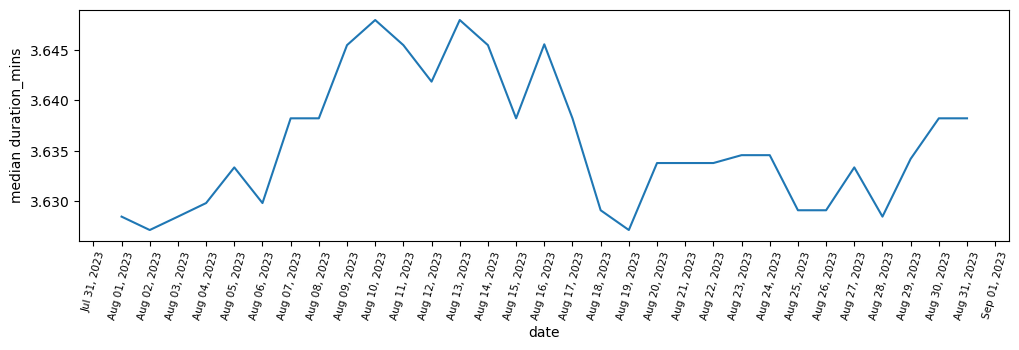

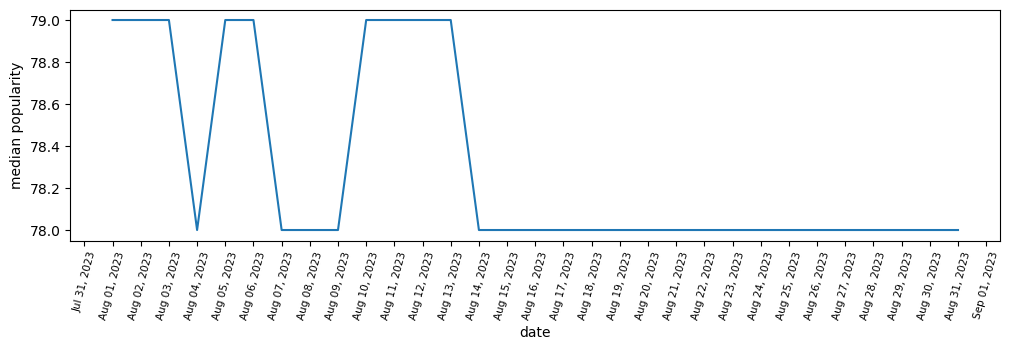

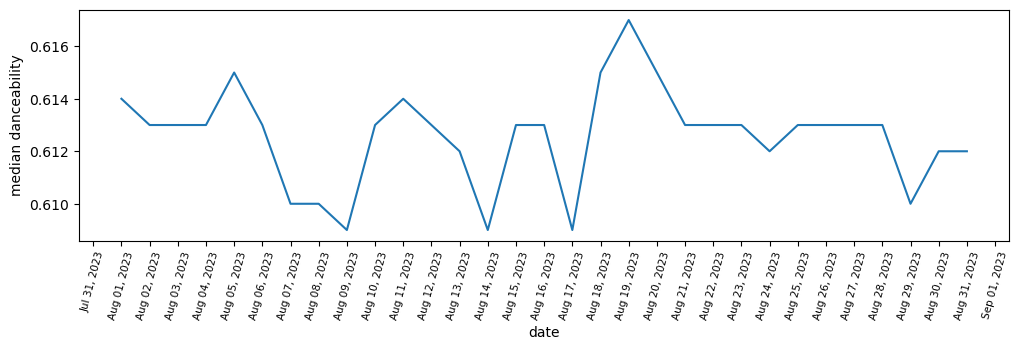

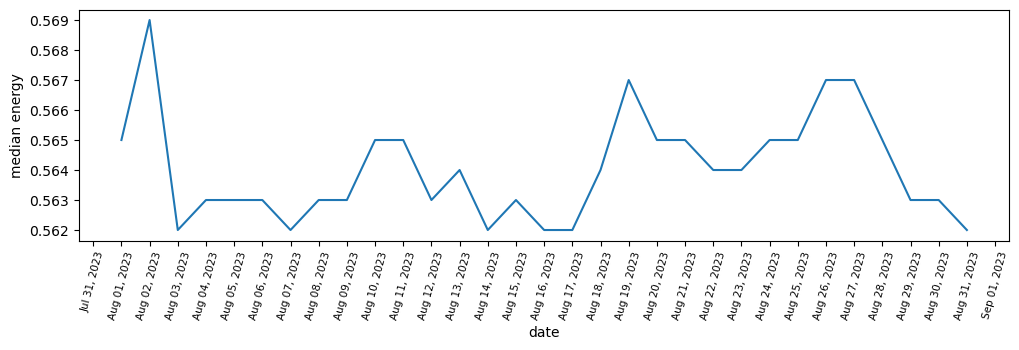

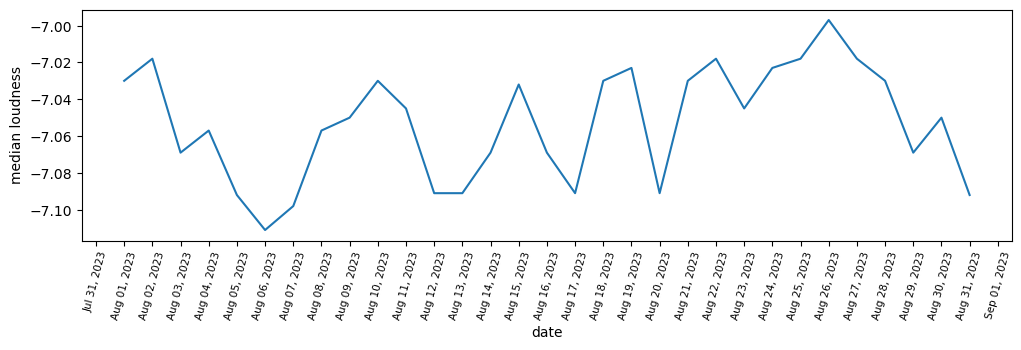

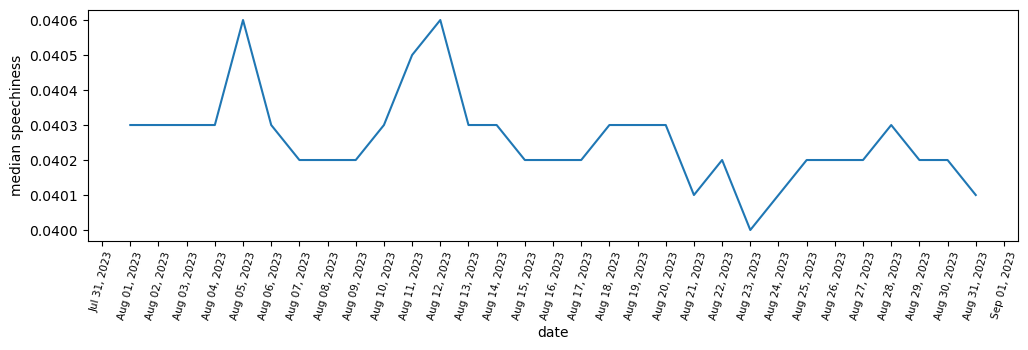

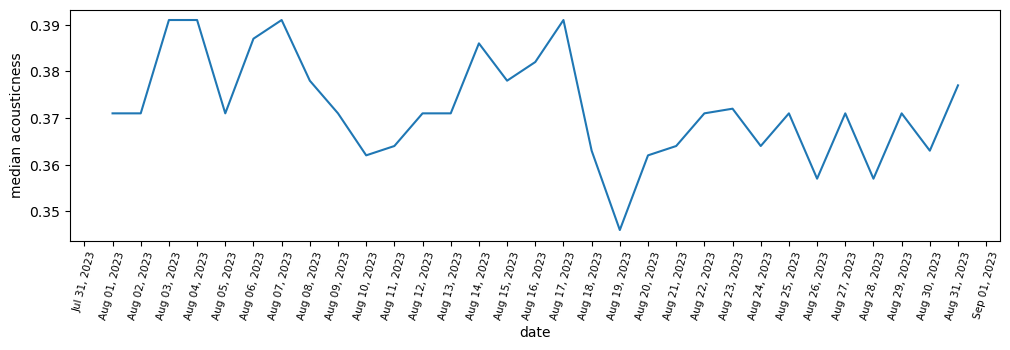

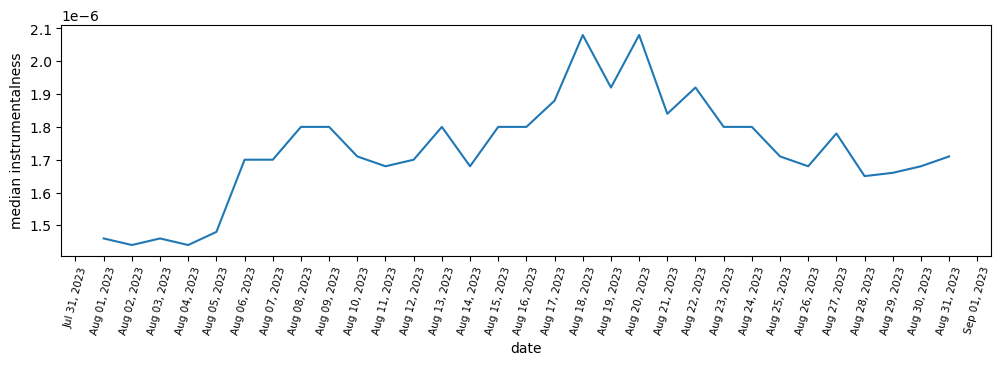

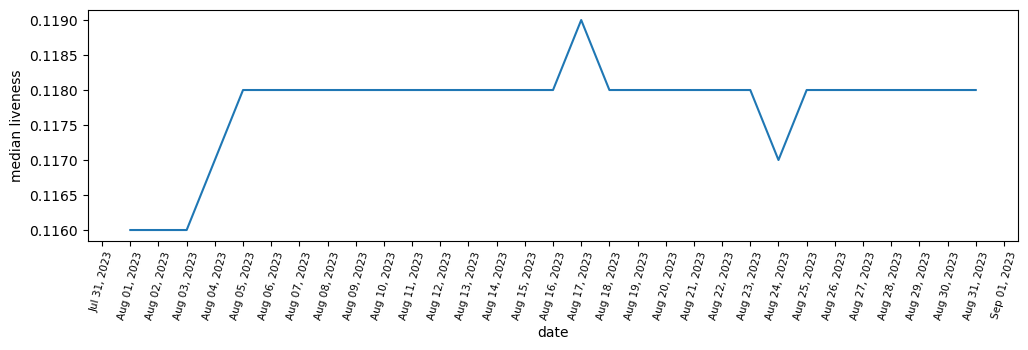

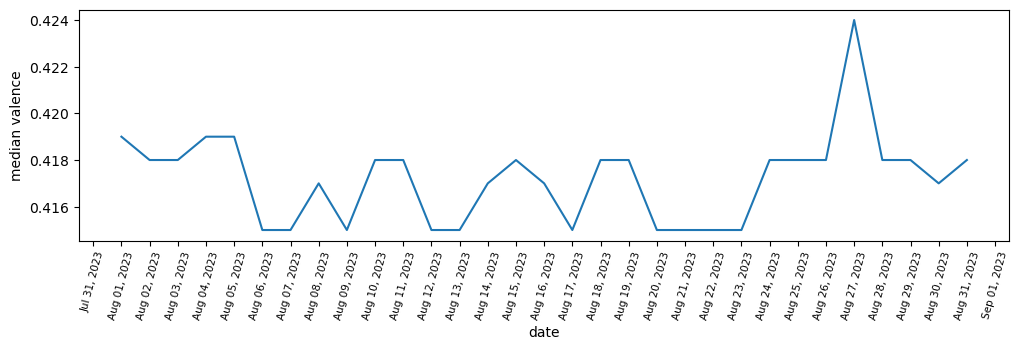

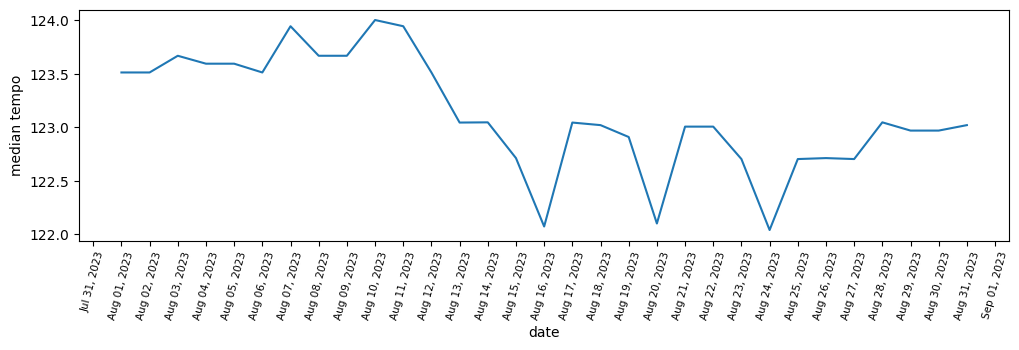

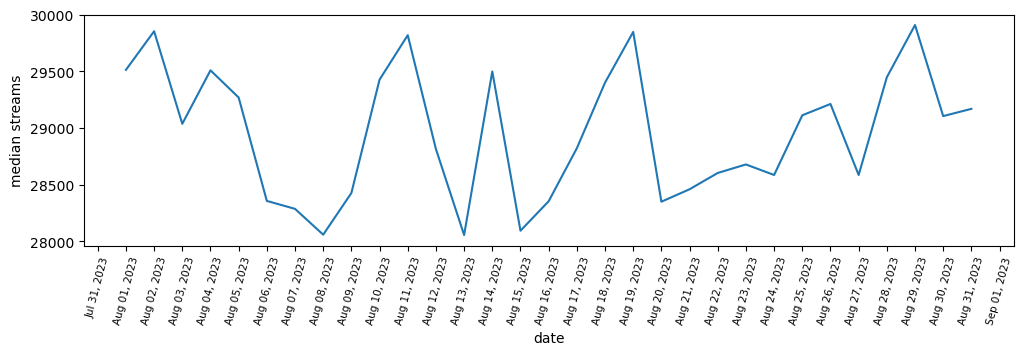

In [77]:
stat_metric = "median";
period = "D";
for feature in features:
    plot_feature(feature, stat_metric, period, charts_track_data_df)